In [316]:
import os
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import torch.nn as nn

In [317]:
big_data = pd.read_csv('/Users/ohmpatel/Desktop/big_data.csv')

In [318]:
big_data = big_data.drop(['Unnamed: 0', 'game_id', 'game_date'], axis = 1)

In [323]:
bad_rows = []
for idx, row in big_data.iterrows():
    if idx % 2000 == 0: print(idx)
    if str(row['run_location']) == "nan" and str(row['pass_location']) == "nan":
        bad_rows.append(idx)
big_data.drop(bad_rows, inplace=True)

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
30000
32000
34000
36000
38000
40000
42000
44000
48000
50000
52000
54000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000
144000
146000
148000
150000
152000
154000
156000
158000
160000
162000
164000
166000
168000
170000
172000
174000
176000
178000
180000
182000
184000
186000
188000
190000
192000
194000
196000
198000
200000
202000
204000
206000
208000
210000
212000
214000
216000
218000
220000
222000
224000
226000
228000
230000
232000
234000
236000
238000


In [324]:
big_data.shape

(228927, 26)

In [325]:
# cut down number of defense packages
dp_freq = dict(big_data['defense_personnel'].value_counts())
dp_freq[np.NaN] = 0
defense_package = []
for idx, row in big_data.iterrows():
    if dp_freq[row['defense_personnel']] < 450 or row['defense_personnel'] == np.NaN:
        defense_package.append(np.NaN)
    else:
        defense_package.append(row['defense_personnel'])
big_data = big_data.drop(['defense_personnel'],axis=1)
big_data['defense_personnel'] = defense_package

# cut down number of offense packages
op_freq = dict(big_data['offense_personnel'].value_counts())
op_freq[np.NaN] = 0
offense_package = []
for idx, row in big_data.iterrows():
    if op_freq[row['offense_personnel']] < 450 or row['offense_personnel'] == np.NaN:
        offense_package.append(np.NaN)
    else:
        offense_package.append(row['offense_personnel'])
big_data = big_data.drop(['offense_personnel'],axis=1)
big_data['offense_personnel'] = offense_package

In [326]:
outcome_run_pass = []
outcome_buckets = []
for idx, row in big_data.iterrows():
    if row['play_type'] == 'pass':
        outcome_run_pass.append('pass')
        outcome_buckets.append('pass + ' + str(row['pass_location']))
    elif row['play_type'] == 'run':
        outcome_run_pass.append('run')
        outcome_buckets.append('run + ' + str(row['run_location']))

In [327]:
len(outcome_run_pass)

228927

In [328]:
X = big_data.drop(['play_sequence_num','pass_length', 'home_team', 'away_team', 'pass_location', 'run_location', 'play_type', 'surface'], axis=1)

In [329]:
X.head()

,yardline_100,game_seconds_remaining,down,ydstogo,no_huddle,shotgun,posteam_timeouts_remaining,defteam_timeouts_remaining,score_differential,roof,offense_formation,defenders_in_box,feelslike,humidity,conditions,windspeed,defense_personnel,offense_personnel
0,86.0,3597.0,1.0,10.0,0.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
1,80.0,3572.0,2.0,4.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,6.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
2,75.0,3541.0,1.0,10.0,1.0,1.0,3.0,3.0,0.0,outdoors,SHOTGUN,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
3,75.0,3515.0,2.0,10.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,7.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","2 RB, 1 TE, 2 WR"
4,66.0,3474.0,3.0,1.0,1.0,0.0,3.0,3.0,0.0,outdoors,I_FORM,8.0,79.0,61.1,Partially cloudy,12.0,"4 DL, 3 LB, 4 DB","1 RB, 2 TE, 2 WR"


In [330]:
X.fillna(0, inplace=True)

In [332]:
X = pd.get_dummies(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.75)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [333]:
X_pca.shape

(228927, 42)

In [334]:
X.columns

Index(['yardline_100', 'game_seconds_remaining', 'down', 'ydstogo',
       'no_huddle', 'shotgun', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'score_differential', 'defenders_in_box',
       'feelslike', 'humidity', 'windspeed', 'roof_closed', 'roof_dome',
       'roof_open', 'roof_outdoors', 'offense_formation_0',
       'offense_formation_EMPTY', 'offense_formation_I_FORM',
       'offense_formation_JUMBO', 'offense_formation_PISTOL',
       'offense_formation_SHOTGUN', 'offense_formation_SINGLEBACK',
       'offense_formation_WILDCAT', 'conditions_Clear', 'conditions_Overcast',
       'conditions_Partially cloudy', 'conditions_Rain',
       'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy',
       'conditions_Snow', 'conditions_Snow, Overcast',
       'conditions_Snow, Partially cloudy',
       'conditions_Snow, Rain, Freezing Drizzle/Freezing Rain, Overcast',
       'conditions_Snow, Rain, Overcast',
       'conditions_Snow, Rain, Partially cl

In [335]:
X.shape

(228927, 72)

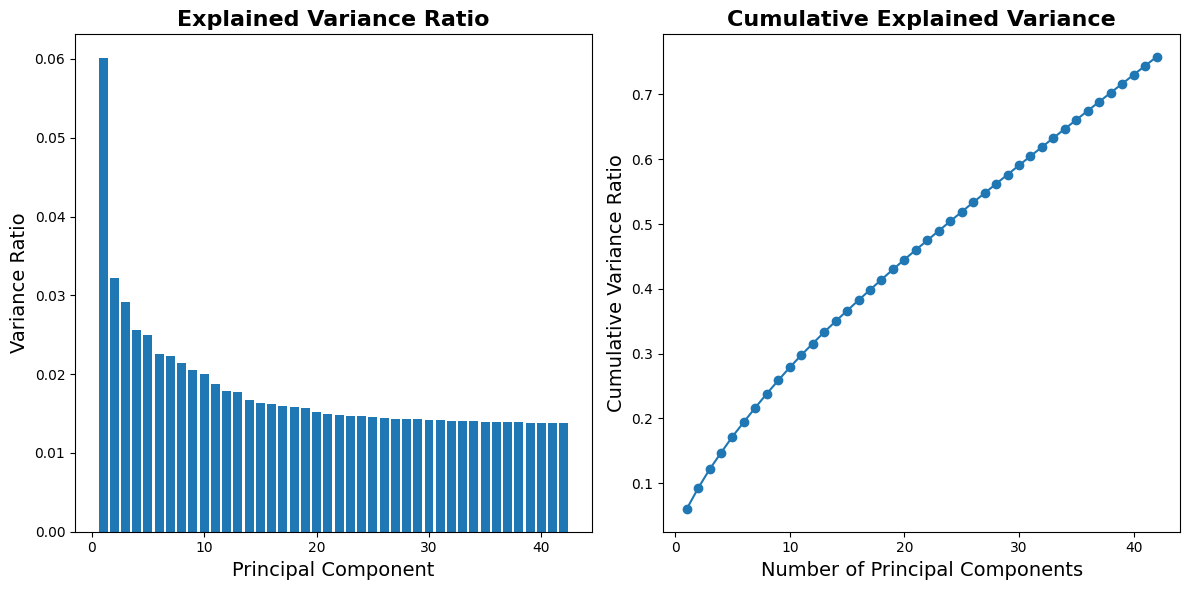

In [336]:
# Plotting the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Increase fontsize and bold text
plt.figure(figsize=(12, 6))

# Plot the explained variance ratio
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.title('Explained Variance Ratio', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Variance Ratio', fontsize=14)

# Plot the cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance', fontsize=16, fontweight='bold')
plt.xlabel('Number of Principal Components', fontsize=14)
plt.ylabel('Cumulative Variance Ratio', fontsize=14)

plt.tight_layout()
plt.show()

In [337]:
loadings = pca.components_

# Creating a DataFrame for better visualization
# Assuming df.columns gives the original feature names
loadings_df = pd.DataFrame(data=loadings, columns=X.columns, index=[f'PC{i}' for i in range(loadings.shape[0])])

In [338]:
feature_importances = np.sum(loadings**2, axis=0)
feature_ranking = np.argsort(feature_importances)[::-1]

In [339]:
feature_ranking

array([45, 34, 68, 39, 67, 49, 62, 36, 47, 32, 29, 53, 42, 26, 24, 43, 40,
       46, 64, 69, 41, 30, 35, 50, 27, 58, 54, 63, 13, 48, 66, 33, 70, 61,
       21, 14, 51, 44, 28, 25, 15, 57, 16, 38, 12, 52, 18, 65, 59,  3,  4,
       31, 11,  2, 10, 19, 23,  8, 22, 71, 60, 17, 20, 55,  5,  0,  6,  7,
        1, 56, 37,  9])

In [340]:
feature_importances

array([0.32816791, 0.31937028, 0.44634241, 0.49615442, 0.47893914,
       0.33438854, 0.32782006, 0.32616728, 0.40405903, 0.27314476,
       0.44120735, 0.46121934, 0.53611948, 0.64207195, 0.59071598,
       0.54413807, 0.53831688, 0.367387  , 0.52227627, 0.41234771,
       0.35977454, 0.60817055, 0.40059686, 0.41216938, 0.75433994,
       0.55212166, 0.75850163, 0.65949412, 0.56471531, 0.78044435,
       0.67790893, 0.46943027, 0.7830974 , 0.62771184, 0.88503124,
       0.67333943, 0.79423591, 0.31070397, 0.53684135, 0.85053711,
       0.75179574, 0.69771332, 0.77039509, 0.75364748, 0.58143685,
       0.88813226, 0.73305558, 0.7937506 , 0.63562931, 0.81436764,
       0.6702165 , 0.58879812, 0.52521502, 0.77088417, 0.65545473,
       0.34077286, 0.31760071, 0.54120418, 0.65655656, 0.5094084 ,
       0.37258983, 0.61163029, 0.80126288, 0.65455073, 0.72839332,
       0.51650908, 0.63253971, 0.83820325, 0.88478506, 0.70894169,
       0.61524851, 0.38979088])

In [341]:
list(X.columns)[34]
features = []
for feature_idx in feature_ranking:
    features.append(list(X.columns)[feature_idx])

In [342]:
features

['defense_personnel_3 DL, 1 LB, 7 DB',
 'conditions_Snow, Rain, Freezing Drizzle/Freezing Rain, Overcast',
 'offense_personnel_6 OL, 1 RB, 1 TE, 2 WR',
 'defense_personnel_1 DL, 4 LB, 6 DB',
 'offense_personnel_6 OL, 1 RB, 0 TE, 3 WR',
 'defense_personnel_4 DL, 1 LB, 6 DB',
 'offense_personnel_1 RB, 3 TE, 1 WR',
 'conditions_Snow, Rain, Partially cloudy',
 'defense_personnel_3 DL, 3 LB, 5 DB',
 'conditions_Snow, Overcast',
 'conditions_Rain, Overcast',
 'defense_personnel_5 DL, 1 LB, 5 DB',
 'defense_personnel_2 DL, 3 LB, 6 DB',
 'conditions_Overcast',
 'offense_formation_WILDCAT',
 'defense_personnel_2 DL, 4 LB, 5 DB',
 'defense_personnel_1 DL, 5 LB, 5 DB',
 'defense_personnel_3 DL, 2 LB, 6 DB',
 'offense_personnel_2 RB, 0 TE, 3 WR',
 'offense_personnel_6 OL, 1 RB, 2 TE, 1 WR',
 'defense_personnel_2 DL, 2 LB, 7 DB',
 'conditions_Rain, Partially cloudy',
 'conditions_Snow, Rain, Overcast',
 'defense_personnel_4 DL, 2 LB, 5 DB',
 'conditions_Partially cloudy',
 'offense_personnel_0 RB, 

In [343]:
data = pd.DataFrame()
for feature in feature_ranking[:60]:
    data[feature] = X_scaled[:,feature]

In [344]:
data.shape

(228927, 60)

In [345]:
data

,45,34,68,39,67,49,62,36,47,32,...,4,31,11,2,10,19,23,8,22,71
0,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,-0.323722,-0.023745,-0.362169,-0.955241,1.248978,3.187917,-0.579746,0.146114,-1.048771,-0.058509
1,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,3.089068,-0.023745,-0.362169,0.263123,1.248978,-0.313684,-0.579746,0.146114,0.953497,-0.058509
2,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,3.089068,-0.023745,-0.362169,-0.955241,1.248978,-0.313684,-0.579746,0.146114,0.953497,-0.058509
3,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,3.089068,-0.023745,-0.362169,0.263123,1.248978,3.187917,-0.579746,0.146114,-1.048771,-0.058509
4,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,3.089068,-0.023745,-0.362169,1.481487,1.248978,3.187917,-0.579746,0.146114,-1.048771,-0.058509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228922,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,5.307202,-0.147723,-0.405310,-0.052573,...,-0.323722,-0.023745,-0.362169,-0.955241,-0.813353,-0.313684,-0.579746,-0.044403,0.953497,-0.058509
228923,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,5.307202,-0.147723,-0.405310,-0.052573,...,-0.323722,-0.023745,-0.362169,-0.955241,-0.813353,-0.313684,1.724893,-0.044403,-1.048771,-0.058509
228924,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,-0.405310,-0.052573,...,-0.323722,-0.023745,-0.362169,0.263123,-0.813353,-0.313684,-0.579746,-0.044403,0.953497,-0.058509
228925,-0.048399,-0.022805,-0.106763,-0.125487,-0.045934,-0.181822,-0.188423,-0.147723,2.467246,-0.052573,...,-0.323722,-0.023745,-0.362169,-0.955241,-0.813353,-0.313684,-0.579746,-0.044403,0.953497,-0.058509


In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228927 entries, 0 to 228926
Data columns (total 60 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   45      228927 non-null  float64
 1   34      228927 non-null  float64
 2   68      228927 non-null  float64
 3   39      228927 non-null  float64
 4   67      228927 non-null  float64
 5   49      228927 non-null  float64
 6   62      228927 non-null  float64
 7   36      228927 non-null  float64
 8   47      228927 non-null  float64
 9   32      228927 non-null  float64
 10  29      228927 non-null  float64
 11  53      228927 non-null  float64
 12  42      228927 non-null  float64
 13  26      228927 non-null  float64
 14  24      228927 non-null  float64
 15  43      228927 non-null  float64
 16  40      228927 non-null  float64
 17  46      228927 non-null  float64
 18  64      228927 non-null  float64
 19  69      228927 non-null  float64
 20  41      228927 non-null  float64
 21  30      22

In [347]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228927 entries, 0 to 239531
Data columns (total 72 columns):
 #   Column                                                           Non-Null Count   Dtype  
---  ------                                                           --------------   -----  
 0   yardline_100                                                     228927 non-null  float64
 1   game_seconds_remaining                                           228927 non-null  float64
 2   down                                                             228927 non-null  float64
 3   ydstogo                                                          228927 non-null  float64
 4   no_huddle                                                        228927 non-null  float64
 5   shotgun                                                          228927 non-null  float64
 6   posteam_timeouts_remaining                                       228927 non-null  float64
 7   defteam_timeouts_remaining        

In [348]:
result_d = {}
i = 0
for outcome in set(outcome_buckets):
  if outcome not in result_d:
    result_d[outcome] = i
    i+=1

In [349]:
y_multi = []
for dec in outcome_buckets:
    y_multi.append(result_d[dec])

In [350]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data, outcome_run_pass, test_size=0.2, random_state=3)

In [351]:
model_1 = LogisticRegression(solver='lbfgs', max_iter=10000)
model_1.fit(X_train_1, y_train_1)

y_pred_1 = model_1.predict(X_test_1)

accuracy_1 = accuracy_score(y_test_1, y_pred_1)
print(f'Model Accuracy: {accuracy_1:.2f}')

Model Accuracy: 0.72


In [352]:
accuracy_1

0.7239767614554667

In [353]:
y_val = list(model_1.coef_[0])
top_60 = feature_ranking[:60]
x_val = [list(X.columns)[feat] for feat in top_60]

pairs = []
for i in range(len(y_val)):
    pairs.append((x_val[i], y_val[i]))

In [354]:
sorted_by_coeff = (sorted(pairs, key=lambda tup: tup[1] ** 2, reverse=True))
sorted_by_coeff

[('offense_formation_EMPTY', -0.8259752460941692),
 ('offense_formation_SHOTGUN', -0.6888304289420574),
 ('down', -0.3496623195505119),
 ('ydstogo', -0.3373298014986584),
 ('score_differential', 0.20938362967996216),
 ('defense_personnel_4 DL, 2 LB, 5 DB', 0.12919304120430808),
 ('defense_personnel_3 DL, 3 LB, 5 DB', 0.1131790552940085),
 ('offense_personnel_6 OL, 1 RB, 2 TE, 1 WR', 0.10854768525821934),
 ('offense_personnel_6 OL, 2 RB, 1 TE, 1 WR', 0.10182930088980365),
 ('defense_personnel_2 DL, 4 LB, 5 DB', 0.09450680963256433),
 ('defense_personnel_4 DL, 3 LB, 4 DB', 0.09041784908203383),
 ('defense_personnel_3 DL, 4 LB, 4 DB', 0.08862857566112546),
 ('offense_personnel_2 RB, 2 TE, 1 WR', 0.08407129115750775),
 ('no_huddle', -0.08227401318714701),
 ('defense_personnel_1 DL, 4 LB, 6 DB', -0.07427502177794726),
 ('defense_personnel_3 DL, 2 LB, 6 DB', -0.05180906330664741),
 ('offense_formation_WILDCAT', 0.0492334531115264),
 ('defense_personnel_1 DL, 5 LB, 5 DB', -0.04462472259418727

<BarContainer object of 60 artists>

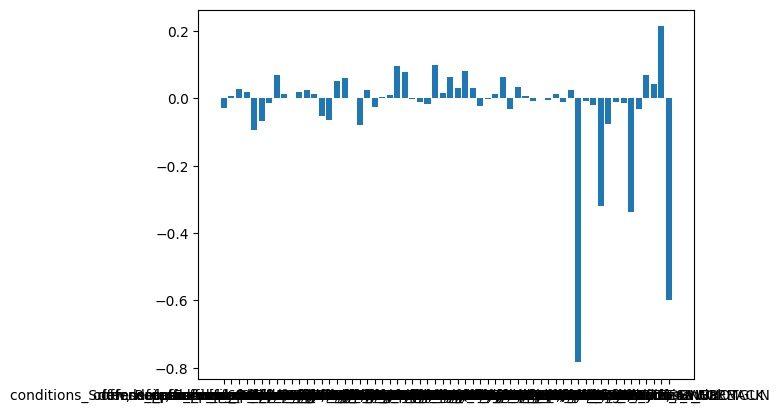

In [300]:
plt.bar(x_val, y_val)

In [298]:
model_1.coef_[0]

array([-2.84238788e-02,  6.81930465e-03,  2.78410512e-02,  1.84569081e-02,
       -9.52267196e-02, -6.68823559e-02, -1.32550528e-02,  6.81667539e-02,
        1.28706561e-02, -2.21872963e-04,  1.97750005e-02,  2.58948734e-02,
        1.35629490e-02, -5.35766955e-02, -6.57750564e-02,  5.12580591e-02,
        5.89325501e-02, -4.36210411e-05, -7.81660639e-02,  2.36063838e-02,
       -2.46384842e-02,  3.22913378e-03,  9.13013821e-03,  9.44794618e-02,
        7.71172203e-02, -2.55587938e-03, -1.11487788e-02, -1.71406034e-02,
        1.00093599e-01,  1.59082262e-02,  6.29489982e-02,  3.03931236e-02,
        8.14989483e-02,  2.93042955e-02, -2.43675017e-02, -2.33336683e-03,
        1.18510285e-02,  6.38726463e-02, -3.14580045e-02,  3.45918918e-02,
        8.00520683e-03, -8.60851561e-03,  1.97922165e-03, -3.82371031e-03,
        1.15769606e-02, -9.63372905e-03,  2.33766180e-02, -7.84278241e-01,
       -7.72627583e-03, -1.86138002e-02, -3.21120470e-01, -7.51577928e-02,
       -1.13325870e-02, -

In [355]:
class_report = classification_report(y_test_1, y_pred_1)
print("\nClassification Report:")
print(class_report)



Classification Report:
              precision    recall  f1-score   support

        pass       0.74      0.79      0.77     26210
         run       0.70      0.63      0.66     19576

    accuracy                           0.72     45786
   macro avg       0.72      0.71      0.71     45786
weighted avg       0.72      0.72      0.72     45786



In [231]:
accuracy

0.726073433944935

Confusion Matrix:
[[20811  5399]
 [ 7239 12337]]


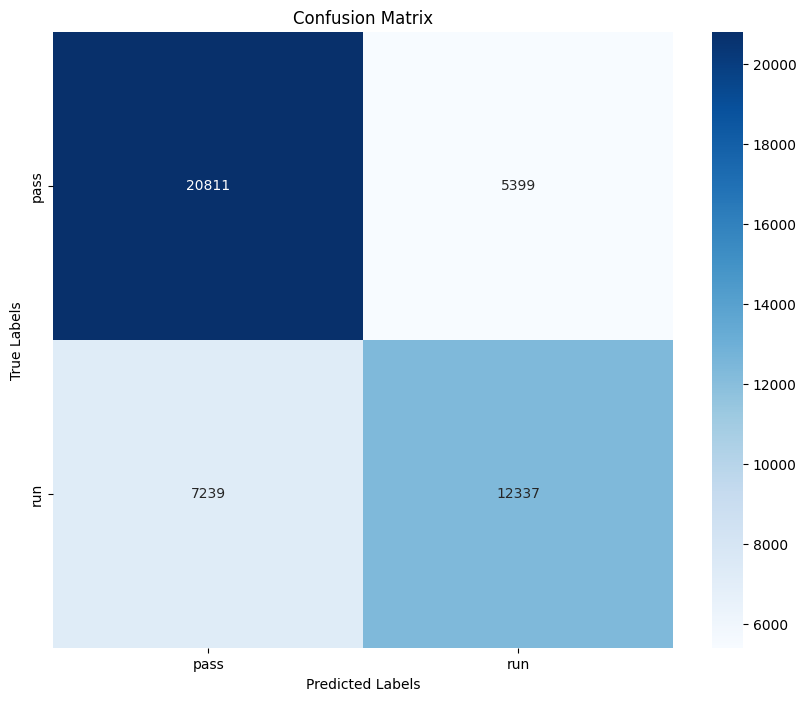

In [356]:
cm = confusion_matrix(y_test_1, y_pred_1)

print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pass', 'run'], yticklabels=['pass', 'run'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

array([[-4.93436254e-01,  1.95112554e-01,  2.64724968e-01,
         4.08938653e-01, -7.33120730e-01, -3.65511177e-01,
        -8.52542356e-02,  2.07882113e-01,  1.41620690e-01,
         1.58364097e-01,  3.82054551e-01,  1.42323111e-01,
         2.12296412e-01, -2.36633726e-01, -7.28541106e-01,
         7.95532014e-01,  1.80425930e-01,  1.61192537e-01,
        -4.45929489e-01,  2.62807738e-01, -4.25294490e-01,
         1.83723298e-01,  1.84038261e-01,  8.89873805e-01,
         1.83242540e-01,  1.56201416e-01, -1.85646698e-01,
        -3.39490043e-02,  1.46142374e+00,  3.56237459e-01,
         2.15459360e-01,  6.47773536e-01,  5.25115585e-01,
         6.44066826e-01, -6.25019948e-02, -3.68702359e-02,
         7.22389405e-02,  1.94811964e-01,  2.18717435e-01,
         4.95976208e-01,  9.97110212e-02,  1.41348507e-01,
         3.22333929e-01,  1.11737016e-01,  3.35308639e-01,
        -1.79622288e-01,  4.04131730e-03, -2.83124541e+00,
        -6.49348518e-02, -6.94240444e-02, -8.07223608e-0

In [357]:
X_train, X_test, y_train, y_test = train_test_split(data, outcome_buckets, test_size=0.2, random_state=3)

In [358]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.28


In [363]:
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
               precision    recall  f1-score   support

  pass + left       0.30      0.12      0.18      9648
pass + middle       0.22      0.00      0.00      5980
 pass + right       0.29      0.67      0.40     10582
   run + left       0.27      0.39      0.32      7175
 run + middle       0.29      0.07      0.12      5327
  run + right       0.27      0.21      0.24      7074

     accuracy                           0.28     45786
    macro avg       0.27      0.25      0.21     45786
 weighted avg       0.28      0.28      0.23     45786



Confusion Matrix:
[[ 994   18    8 6632 1168  103    0  748]
 [ 744   18   10 4434  555   57    0  338]
 [ 158    3   37 1249  244   64    2  153]
 [1037   26    8 7148 1389  122    0  824]
 [ 233    1    7 2283 2646  285    0 1689]
 [ 228    1   11 2089 1582  432    0 1089]
 [   7    0    9   68   44   18    2   38]
 [ 224    1    9 2228 2439  290    0 1663]]


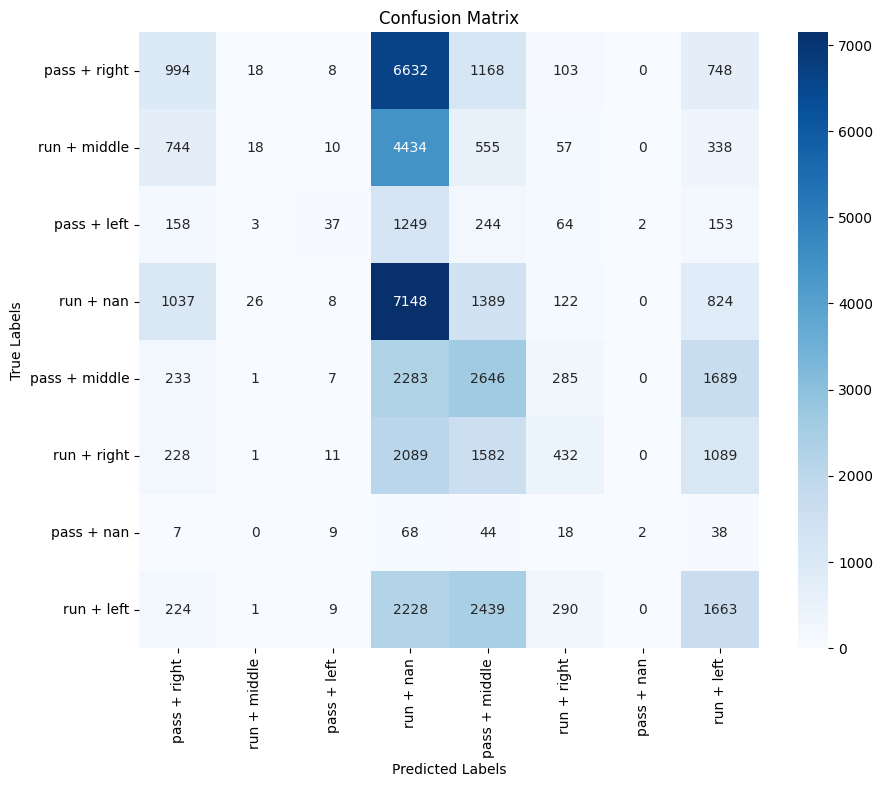

In [315]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=result_d.keys(), yticklabels=result_d.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [359]:
len(model.coef_[0])

60

In [360]:
freq = dict(pd.Series(outcome_buckets).value_counts())

In [361]:
total = sum(freq.values())
for play in freq:
    freq[play] /= total

In [362]:
freq

{'pass + right': 0.2303354344397996,
 'pass + left': 0.21161767725082667,
 'run + left': 0.1558313348796778,
 'run + right': 0.15292211054178842,
 'pass + middle': 0.1328021596404094,
 'run + middle': 0.1164912832474981}

In [367]:
dict(pd.Series(outcome_run_pass))['pass'] / len(outcome_run_pass)

KeyError: 'pass'

In [265]:
run, pass_c = 0, 0
for play in outcome_run_pass:
    if play == 'pass':
        pass_c += 1
    else:
        run += 1
print(run / (run + pass_c), pass_c / (run + pass_c))

0.41053804919593206 0.5894619508040679


In [268]:
cm[0][0] / sum(cm[0])

0.7938567035452971

In [270]:
cm[1][1] / sum(cm[1])

0.6283136215334421

In [365]:
y_val = list(model_1.coef_[0])
top_60 = feature_ranking[:60]
x_val = [list(X.columns)[feat] for feat in top_60]

pairs = []
for i in range(len(y_val)):
    pairs.append((x_val[i], y_val[i]))
    
sorted_by_coeff = (sorted(pairs, key=lambda tup: tup[1] ** 2, reverse=True))


In [369]:
result_d

{'pass + right': 0,
 'run + middle': 1,
 'pass + left': 2,
 'pass + middle': 3,
 'run + right': 4,
 'run + left': 5}

In [370]:
x_val = [list(X.columns)[feat] for feat in top_60]
for key in result_d:
    print(key) 
    pairs = []
    for i in range(len(y_val)):
        pairs.append((x_val[i], y_val[i]))
    print( (sorted(pairs, key=lambda tup: tup[1] ** 2, reverse=True))[:10] )
    

pass + right
[('offense_formation_EMPTY', -0.8259752460941692), ('offense_formation_SHOTGUN', -0.6888304289420574), ('down', -0.3496623195505119), ('ydstogo', -0.3373298014986584), ('score_differential', 0.20938362967996216), ('defense_personnel_4 DL, 2 LB, 5 DB', 0.12919304120430808), ('defense_personnel_3 DL, 3 LB, 5 DB', 0.1131790552940085), ('offense_personnel_6 OL, 1 RB, 2 TE, 1 WR', 0.10854768525821934), ('offense_personnel_6 OL, 2 RB, 1 TE, 1 WR', 0.10182930088980365), ('defense_personnel_2 DL, 4 LB, 5 DB', 0.09450680963256433)]
run + middle
[('offense_formation_EMPTY', -0.8259752460941692), ('offense_formation_SHOTGUN', -0.6888304289420574), ('down', -0.3496623195505119), ('ydstogo', -0.3373298014986584), ('score_differential', 0.20938362967996216), ('defense_personnel_4 DL, 2 LB, 5 DB', 0.12919304120430808), ('defense_personnel_3 DL, 3 LB, 5 DB', 0.1131790552940085), ('offense_personnel_6 OL, 1 RB, 2 TE, 1 WR', 0.10854768525821934), ('offense_personnel_6 OL, 2 RB, 1 TE, 1 WR',